# Theory


We imagine a collection of Erdos-Renyi Random Graphs.

Want to calculate the probability distribution of the distribution of infecteds $x$ among the different graphs, given the overall fraction of infected $y$.

If we let $x_i$ be the fraction of infecteds in subgraph $i$, we expect a universal probability distribution $P(x_i | y)$. Due to symmetry, we further expect $P(x_i | y) = P(x|y)$ to be independent of $i$.

If we assume stationarity, we can find an equilibrium distribution $P(x | y)$. I.e. we assume an overal prevalence $y$ of infecteds, and conditioned on this $y$ find which stationary distribution of $x$ emerges.

Given $P(x | y)$ we can calculate $<x>$ and $<x^2>$, which gives us an $s_{eff}(x)$ in each of the subgraphs. 

We expect $x$ to be concentrated as $y$ is small, and then we expect it to gradually spread out as $y$ becomes larger.

## Stationary Distribution $P(x | y)$

Assume we have a regular two-level erdos-renyi graph with N total nodes. There are $n$ subgraphs of $m$ nodes each. Each node has $r$ connections randomly among all other subgraphs and $l$ connections randomly among its own subgraph.

We assume that for each individual independently

$$P_{death} \sim N \bar{y} (1 - y) (1 + \beta)$$
$$P_{birth} \sim N y (1 - \bar{y}) (1 + \alpha y)$$

$y$ stands for the local density, whereas $\bar{y}$ stands for the average density throughout the entire graph.
The $y (1 - y)$ terms arise in different ways. In the death process, we require an infected to die ($\bar{y}$) pick the type (infected or susceptible) from a random neighbor upon death ($1 - y$). For the birth process, we need to be susceptible ($1 - \bar{y}$) in order to undergo birth in the first place. However we have an independent probability from each neighbor of being infected ($y$). If we want to find the expectation of these quantities, we need

$$N_{death} \sim N \bar{y} (1 - <y>) (1 + \beta)$$
$$N_{birth} \sim N (1 - \bar{y}) (<y> + \alpha <y^2>)$$

per individual, we have

$$P_{death} \sim (1 - <y>) (1 + \beta)$$
$$P_{birth} \sim (<y> + \alpha <y^2>)$$

Due to the nonlinearity, we need the expectation of $<y^2>$ as well.

Now describe our system by a vector $\vec{a} = (a_0, a_1, ... , a_m)$ Where $a_j$ describes the number of subgraphs with $j$ infecteds. We of course only have $n$ subnodes, which requires
$$\sum_{j = 0}^m a_j = n $$
Since we must have $N y$ infecteds total, this requires a normalization
$$\sum_{j = 0}^m j a_j = N y$$

We imagine a stationary process where we randomly remove one infected individual and then randomly add one infected invidual. This process should relax to an equilibrium distribution

### Transition probabilities

Let us consider a node in a subgraph with $j$ total infecteds. This node has degree $r + l$. Let us find out $y$. We know inside the subgraph the prevalence is $\frac{j}{m}$. Outside, the prevalence is $\bar{y}$. Thus, we have $y = \frac{i_r + i_l}{r + l}$, where $i_r$ and $i_l$ are binomially distributed random variables:
$$i_l \sim Binom(l,\frac{j}{m})$$
$$i_r \sim Binom(r,\bar{y})$$

With means $<i_l> = \frac{l j}{m}$ and $<i_r> = r \bar{y}$. Thus we have $$y_{local} = y = \frac{l \frac{j}{m} +r \bar{y}}{l  + r}$$
in expectation. If the nodes is itself infected, it is part of the $j$ nodes, so we would really have
$$y_{local} = y = \frac{l \frac{j-1}{m} +r \bar{y}}{l  + r}$$ in that case.

For $<y^2>$ we have 
$$<y^2> = \left< \frac{i_r^2 + i_r i_l + i_l^2}{(r + l)^2} \right> = 
\frac{<i_r^2> + <i_l^2> + 2<i_r><i_l>}{(r + l)^2} = \frac{r \bar{y} ((r - 1) \bar{y} + 1) + l \frac{j}{m}((l - 1) \frac{j}{m} + 1) + 2 l r \frac{j}{m} \bar{y}}{(r + l)^2} $$

We have $Var[x] = E[x^2] - E[x]^2$ For the binomial distribution,
$E[x^2] = Var[x] + E[x]^2 = n p (1 - p)  + n^2 p^2 = n p ((n - 1) p + 1)$

Now consider an individual in a subgraph with $j$ infecteds. If he is infected, his probability of being removed ($a_j -= 1$, $a_{j - 1} += 1$)is

$$a_j j <P_{death,j}> =  a_j j (1 - <y_j>) (1 + \beta)$$

If he is susceptible, his probability of being added is

$$ a_j (m - j) <P_{birth,j}> = (<y_j> + \alpha <y_j^2>) $$

We develop a markov chain where we apply one birth and one death process simultaneously and then observe the resulting equilibrium distribution.

## Calculation of an effective theory

Using the expressions for the *steady state values* of $<y>$ and $<y^2>$ as a function of $j$, we can calculate the overall values of $<y>_{inf}$, $<y>_{susc}$ and $<y^2>_{susc}$. This allows us to run a mean field simulation of the dynamics. 

We expect this simulation to be accurate: 

- below the neutral selection threshold, we are dominated by diffusive behavior. This means the time scale on which $y$ changes is long compared to the time we spend at any given $y$, so we expect to be close to the steady state distribution over nodes.

- above the neutral selection threshold, the epidemic fixes quickly and spends little time, so the effect on the overall results is very small.

In [1]:
push!(LOAD_PATH,pwd())
using StatsBase, PyPlot, Distributions, LightGraphs, TwoLevelGraphs

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
k = 4
#y_n = 0.1
c_r = 0.18
N = 400#100000#400
n_n = 40#10#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n
println("N=$N, alpha = $alpha, beta = $beta")


#Generate a random startin vector
m = 20 #40
n = Int(N/m)
l = Int(m/2)#internal
r = 2#Int(m/2)#2 #external

y_desired = 0.029294


t = TwoLevel(N,m,l,r)
# #distribute_randomly(t,n)
# adjust_infecteds(t,y_desired)
# make_consistent(t)
# assert(is_valid(t))
println(t.i/t.N)

N=400, alpha = 5.555555555555555, beta = 0.5555555555555556
0.0

In [3]:
#num_trials = 1000_000
#accum = get_stationary_distribution(N,m,l,r,y_desired,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)),num_trials)
equilibrium_distribution = get_stationary_distribution_nonlinear_theory(N,m,l,r,y_desired,alpha,beta)[:];;
t.a = equilibrium_distribution
get_frac_infected(t),y_desired
#figure()
#semilogy(accum,"r")

(0.029293899930467274,0.029294)

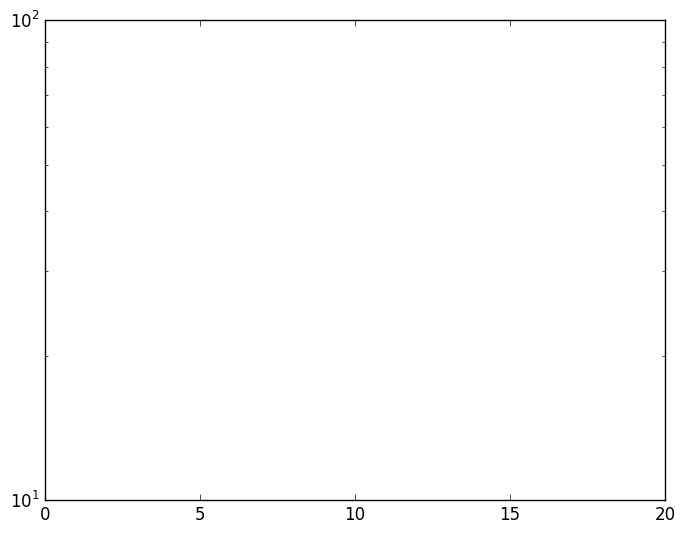

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31d9ef810>

In [25]:
semilogy(equilibrium_distribution,"b")
# semilogy(equilibrium_distribution1,"--b")

#semilogy(accum,"r")
# semilogy(accum1,"--r")

# semilogy(equilibrium_distribution./equilibrium_distribution1,"g")
#semilogy(transition_matrix*accum,"g")

In [5]:
println(sum([(j-1)*equilibrium_distribution[j] for j = 1:length(equilibrium_distribution)])/t.N," ",t.i/t.N)
println(sum(equilibrium_distribution)," ", t.n)

println(sum([(j-1)*accum[j] for j = 1:length(accum)])/t.N, " " , t.i/t.N)
println(sum(accum), " " , t.n)

0.4965590960337027 0.8
20.000000000000004 20
0.8

## Solve the below subject to positivity constraint 

We can compute the flow of infecteds up and down. This should sum up to zero. We find that in the transition matrix method this is not true, but that a stationary solution does have the property that the infected flow is zero. However, the infected value reached is not equal to the original infected value. 

In [10]:
#Pkg.add("JuMP")
using JuMP

In [20]:
A = [net_flow_vec(m) net_infected_vec(t) net_total_vec(t)]'
b = [0; y_desired; t.n]
#println(A," ", b)
accum_th = A\b

21-element Array{Float64,1}:
 10.1019  
  4.02517 
 -0.441752
 -3.47549 
 -5.25267 
 -5.9499  
 -5.7438  
 -4.811   
 -3.32811 
 -1.47175 
  0.581459
  2.6549  
  4.57196 
  6.15601 
  7.23043 
  7.61862 
  7.14394 
  5.62978 
  2.89952 
 -1.22345 
 -6.91576 

In [24]:
#Pkg.add("Ipopt")
jmp = Model()
@defVar(jmp, x[1:(t.m + 1)] >= 0)
@addConstraint(jmp,dot(x,net_flow_vec(m))==0)
@addConstraint(jmp,dot(x,net_total_vec(t))==t.m)
@setObjective(jmp,:Min, (dot(x,net_infected_vec(t))-y_desired)^2)
#@setObjective(jmp,:Min, sum((A*x - b).^2))
status = solve(jmp)
accum_jmp = getValue(x)
A*accum_jmp, b

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       42
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:       21
                     variables with only lower bounds:       21
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

21-element Array{Float64,1}:
  4.60179   
  3.21969e-6
  1.75467e-6
  1.34743e-6
  1.19325e-6
  1.15085e-6
  1.18221e-6
  1.28237e-6
  1.46742e-6
  1.7807e-6 
  2.32086e-6
  3.33054e-6
  5.52961e-6
  1.19058e-5
  4.88602e-5
 15.398     
  8.72257e-5
  1.15587e-5
  4.29882e-6
  2.1795e-6 
  1.29158e-6

In [143]:
accum_eq = propagate_in_time(m,accum,10000) 

0.7999656683753871
total_change: -3.4331624612950216e-5
ratio: 0.9999999999993943
0.5322159896512499
total_change: -0.2677840103487499
ratio: 0.9999999999999992
0.5008074038959861
total_change: -0.2991925961040103
ratio: 0.9999999999999878
0.49706524012884706
total_change: -0.30293475987115337
ratio: 1.0000000000000013
0.4966193980858247
total_change: -0.30338060191418015
ratio: 1.000000000000016
0.49656628042542345
total_change: -0.30343371957458193
ratio: 1.0000000000000175
0.49655995198275454
total_change: -0.3034400480172524
ratio: 1.0000000000000226
0.4965591980115454
total_change: -0.3034408019884586
ratio: 1.0000000000000129
0.49655910818335003
total_change: -0.30344089181665507
ratio: 1.0000000000000167
0.4965590974812166

21-element Array{Any,1}:
 0.170432
 0.43996 
 0.711325
 0.932403
 1.08994 
 1.19055 
 1.24737 
 1.27349 
 1.27944 
 1.27268 
 1.25787 
 1.23728 
 1.21111 
 1.1777  
 1.13346 
 1.07284 
 0.98815 
 0.869855
 0.707818
 0.495406
 0.240921


total_change: -0.3034409025187934
ratio: 1.0000000000000329


Simulation Strategy: first burn in the distribution with neutral transition probabilities to sample different starting configurations. Then apply real transition functions to sample the distribution.

## Transition Matrix

$$da_j/dt = - a_j P_{j\to j-1} - a_j P_{j\to j+1} + a_{j+1} P_{j+1 \to j} + a_{j-1} P_{j-1 \to j}$$


In [2]:
transition_matrix = generate_transition_matrix(t,alpha,beta)
sum(transition_matrix,2)


equilibrium_distribution = nullspace(transition_matrix)
# equilibrium_distribution1 *= t.n/sum(equilibrium_distribution)

LoadError: LoadError: UndefVarError: generate_transition_matrix not defined
while loading In[2], in expression starting on line 1

## Graph generation

We wish to generate two-level Erdos-Renyi random graphs. The central idea is that each individual subgraph is a simple ER random graph. These can be produced independently. Moreover, we can then view each subgraph as a supernode and produce another ER random graph connecting these super nodes with the appropriate amount of edges. In the final step we then uniformly distribute the edges between the super nodes among the actual nodes that make up the super nodes.

## Overall distribution

We want to find out which effective $y$ and $y^2$ arise from a given $\vec{a}$ vector

What is the expected value of $y$ that a randomly chosen node will see?



In [17]:
y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)

(Spline1D(knots=[0.0024655,0.017541 … 0.977498,0.992513] (99 elements), k=2, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[0.0024655,0.017541 … 0.977498,0.992513] (99 elements), k=2, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[0.0024655,0.017541 … 0.977498,0.992513] (99 elements), k=2, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[0.0024655,0.017541 … 0.977498,0.992513] (99 elements), k=2, extrapolation="extrapolate", residual=0.0))

In [18]:
using JLD
JLD.save("../data/interpolations.jld","y_inf_interp",y_inf_interp,"y_sq_inf_interp",y_sq_inf_interp,
"y_susc_interp",y_susc_interp,"y_sq_susc_interp",y_sq_susc_interp)

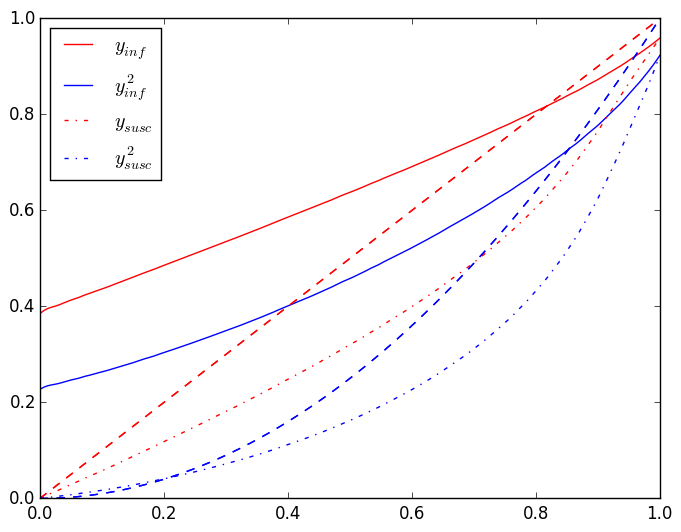

(0,1)

In [19]:
using Dierckx
yy = 0:0.001:1

plot(yy,evaluate(y_inf_interp,yy),"r",label=L"y_{inf}")
plot(yy,yy,"--r")

plot(yy,evaluate(y_sq_inf_interp,yy),"b",label=L"y_{inf}^{2}")
plot(yy,yy.^2,"--b")

plot(yy,evaluate(y_susc_interp,yy),"-.r",label=L"y_{susc}")
plot(yy,yy,"--r")

plot(yy,evaluate(y_sq_susc_interp,yy),"-.b",label=L"y_{susc}^2")
plot(yy,yy.^2,"--b")

legend(loc="upper left")

xlim([0,1])
ylim([0,1])

In [33]:
y_desired_range = 0:0.01:1
y_actual_range = zeros(y_desired_range)
for (i,y_desired) in enumerate(y_desired_range)
    equilibrium_distribution = get_stationary_distribution_theory(N,m,l,r,y_desired,alpha,beta)[:];
    y_actual_range[i] = dot(net_infected_vec(t),equilibrium_distribution)
end
    


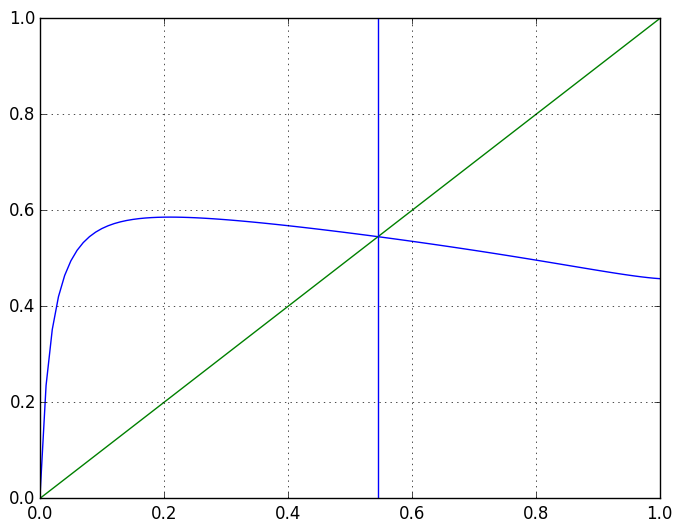

In [57]:
plot(y_desired_range,y_actual_range)
plot(y_desired_range,y_desired_range)
axvline(0.545)
grid()

$$N_{death} \sim N \bar{y} (1 - <y>) (1 + \beta)$$
$$N_{birth} \sim N (1 - \bar{y}) (<y> + \alpha <y^2>)$$

Thus

$$N dy = \sim N ((1 - \bar{y}) (<y>_{susc} + \alpha <y^2>_{susc}) - \bar{y} (1 - <y>_{inf}) (1 + \beta)) dt$$

$$ N \frac{dy}{dt} = s(y) \bar{y}$$

Thus

$$s(y) = \frac{1 - \bar{y}}{\bar{y}} (<y>_{susc} + \alpha <y^2>_{susc}) - (1 - <y>_{inf}) (1 + \beta)$$

# Questions


## Shouldn't we divide by $k_{local}$ in algorithm, as opposed to $k$?

# TODO


## Compute the expectations of $y$ and $y^2$ given an $P(x | y)$. Compute the average $y^2$ that a node sees.

How to compute the expected $y$? Do we have one for susceptibles and infecteds? Do we have them seperately? How do we then compute s_{eff}(y)? Subtract birth from death rate? Make sure to distinguish $\bar{y}$ and $y$ in the formulas!.

compare with actual graph data using s_eff(y,y_squared)

## Try experiments (comparing mcmc and real graph $a$ distributions) using more reasonable parameters (larger $n_n$).

## Make sure equilibrium distribution returns the correct total number of infecteds!


## Try running well mixed model with interpolation functions from the transition matrix method!

In [141]:
# function propagate_in_time(transition,arr,time = 1)
#     dt = 0.05
#     timesteps = round(Int,time/dt)
#     change = similar(arr)
#     total_change = 0.0
#     infected_begin = get_frac_infected(arr,t.N)
#     for i = 1:timesteps
#         total_change += dt*(get_flow_up(transition,arr) - get_flow_down(transition,arr))/t.N
#         arr += dt*transition*arr
#         if i % round(Int,timesteps/10) == 1
#             infected_curr = get_frac_infected(arr,t.N)
#             println(infected_curr)
#             println("total_change: $(total_change)")
#             println("ratio: $(total_change/(infected_curr-infected_begin))")
            
# #             println("change up: $(get_flow_up(transition,arr))")
# #             println("change down: $(get_flow_down(transition,arr))")
            
#         end
#     end
#     return arr
# end


# function get_frac_infected(arr::Array{Any,1},N::Int)
#     y = collect(0:(length(arr)-1))
#     return sum(arr .* y)/N
# end

# function get_frac_infected(arr,t::TwoLevelGraphs.TwoLevel)
#     y = collect(0:(length(arr)-1))
#     return sum(arr .* y)/t.N
# end

# function get_upper_diagonal(arr::Array{Float64,2})
#     assert(size(arr,1) == size(arr,2))
#     ret = zeros(size(arr,1)-1)
#     for i = 1:length(ret)
#         ret[i] = arr[i,i+1]
#     end
#     ret
# end

# function get_lower_diagonal(arr::Array{Float64,2})
#     assert(size(arr,1) == size(arr,2))
#     ret = zeros(size(arr,1)-1)
#     for i = 1:length(ret)
#         ret[i] = arr[i+1,i]
#     end
#     ret
# end

# function get_flow_down(transition,arr)
#     return sum(get_upper_diagonal(transition) .* arr[2:end])
# end


# function get_flow_up(transition,arr)
#     return sum(get_lower_diagonal(transition) .* arr[1:end-1])
# end

# function get_flow_vecs(transition)
#     flow_down_vec = [[0];get_upper_diagonal(transition)]
#     flow_up_vec = [get_lower_diagonal(transition);[0]]
#     return flow_down_vec,flow_up_vec
# end

# function net_flow_vec(transition)
#     flow_down_vec,flow_up_vec = get_flow_vecs(transition)
#     net_flow_vec = (flow_up_vec - flow_down_vec)
#     return net_flow_vec
# end

# function net_infected_vec(t)
#     return collect(0:t.m)/t.N
# end

# function net_total_vec(t)
#     return ones(t.m + 1)
# end

# function compute_gamma(transition,arr)
#     return get_flow_down(transition,arr)/get_flow_up(transition,arr)
# end

# function get_stationary_distribution_from_matrix(t::TwoLevel,transition_matrix)
#   equilibrium_distribution = nullspace(transition_matrix)
#   if size(equilibrium_distribution)[2] > 1 println("PROBLEM: $(size(equilibrium_distribution)[2]) SOLUTIONS"); end
#   equilibrium_distribution = equilibrium_distribution[:,end]
#   equilibrium_distribution *= t.n/sum(equilibrium_distribution)
#   return equilibrium_distribution
# end

# function binary_search_transition_matrix(f_out,y_target)
#     tol = 1e-4
#     max_iter = 1000
#     x_upper = guarantee_upper_bound(f_out,y_target)
#     x_lower = guarantee_lower_bound(f_out,y_target)
#     y_upper = f_out(x_upper) 
#     y_lower = f_out(x_lower) 
    
#     iter = 1
#     while y_upper - y_lower > tol && iter < max_iter
#         x_mid = (x_upper + x_lower)/2
#         y_mid = f_out(x_mid)
#         if y_mid > y_target
#             x_upper = x_mid
#             y_upper = y_mid
#         elseif y_mid < y_target
#             x_lower = x_mid
#             y_lower = y_mid
#         else
#             return x_mid
#         end
#         iter +=1 
#     end
#     if iter >= max_iter
#         println("WARNING: no convergence in transition matrix method. Aborting binary search.")
#     end
#     return (x_upper+x_lower)/2
# end

# function guarantee_upper_bound(f_out,y_target)
#     x_0 = 1.0
#     while f_out(x_0) <= y_target
#         x_0 *= 2
#     end
#     x_0
# end

# function guarantee_lower_bound(f_out,y_target)
#     x_0 = 1.0
#     while f_out(x_0) >= y_target
#         x_0 /= 2
#     end
#     x_0
# end
    

# function get_y_out(t,alpha,beta,gamma)
#     transition = generate_transition_matrix(t,alpha,beta,gamma)
#     arr = get_stationary_distribution_from_matrix(t,transition)
#     gamma_out = compute_gamma(transition,arr)
#     y_out = get_frac_infected(arr,t)
#     y_out
# end

# f_out(x) = get_y_out(t,alpha,beta,x)

# function get_stationary_distribution_nonlinear_theory(t,alpha,beta,y_desired)
#     f_out(x) = get_y_out(t,alpha,beta,x)
#     gamma = binary_search_transition_matrix(f_out,y_desired)
#     transition = generate_transition_matrix(t,alpha,beta,gamma)
#     arr = get_stationary_distribution_from_matrix(t,transition)
#     arr
# end

get_stationary_distribution_from_matrix (generic function with 1 method)

In [ ]:
# function set_y(t::TwoLevel,y_desired::AbstractFloat)
#     adjust_infecteds(t,y_desired)
#     make_consistent(t)
# end    

# function get_interpolations(t::TwoLevel,alpha,beta)
#     y_range = 0:0.05:1.0
#     y_real_range = zeros(y_range)

#     y_eff_range_inf = zeros(y_range)
#     y_sq_eff_range_inf = zeros(y_range)

#     y_eff_range_susc = zeros(y_range)
#     y_sq_eff_range_susc = zeros(y_range)


#     for (i,y_desired) in enumerate(y_range)
#         set_y(t,y_desired)
#         accum = get_stationary_distribution(t.N,t.m,t.l,t.r,y_desired,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)))
#         t.a = accum
#         y_eff_range_inf[i] = compute_mean_y_local(t,false)
#         y_sq_eff_range_inf[i] = compute_mean_y_squared_local(t,false)
#         y_eff_range_susc[i] = compute_mean_y_local(t,true)
#         y_sq_eff_range_susc[i] = compute_mean_y_squared_local(t,true)
#         y_real_range[i] = sum(t.a .*collect(0:t.m))/t.N#get_num_infected(t)/t.N
#     end

#     #yy = collect(0:0.01:1)

#     y_inf_interp = CoordInterpGrid(y_range,y_eff_range_inf,BCnearest,InterpQuadratic)
#     y_susc_interp = CoordInterpGrid(y_range,y_eff_range_susc,BCnearest,InterpQuadratic)
#     y_sq_inf_interp = CoordInterpGrid(y_range,y_sq_eff_range_inf,BCnearest,InterpQuadratic)
#     y_sq_susc_interp = CoordInterpGrid(y_range,y_sq_eff_range_susc,BCnearest,InterpQuadratic)
#     #plot(y_real_range,y_eff_range_susc)
#     #plot(yy,y_susc_interp[yy])
#     return y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp
# end

# function get_s_effective(y,y_susc,y_sq_susc,y_inf,y_sq_inf,alpha,beta)
#     return (1-y)/y*(y_susc + alpha* y_sq_susc) - (1 - y_inf)*(1 + beta)
# end

In [ ]:
# function generate_transition_matrix(t::TwoLevel,alpha,beta)
#     p_plus_arr = zeros(t.m+1)
#     p_minus_arr = zeros(t.m+1)

#     for idx = 1:(t.m + 1)
#         j = idx-1
#         p_plus_arr[idx] = p_j_plus(t,j,alpha)
#         p_minus_arr[idx] = p_j_minus(t,j,beta)
#     end

# #     gamma = sum(p_plus_arr)/sum(p_minus_arr)
# #     p_minus_arr *= gamma
    
#     p_minus_arr /= sum(p_minus_arr)
#     p_plus_arr /= sum(p_plus_arr)
    
    
    
#     println("gamma = $gamma")

#     transition_matrix = zeros(t.m+1,t.m+1)
#     for row = 1:(t.m+1)
#         for col = 1:(t.m+1)
#             if row == col
#                 transition_matrix[row,col] = -p_minus_arr[row] - p_plus_arr[row]
#             elseif row+1 == col
#                 transition_matrix[row,col] += p_minus_arr[row+1]
#             elseif row-1 == col
#                 transition_matrix[row,col] += p_plus_arr[row-1]
#             end
#         end
#     end
#     return transition_matrix
# end
# transition_matrix = generate_transition_matrix(t,alpha,beta)
#sum(transition_matrix,1)


# equilibrium_distribution1 = nullspace(transition_matrix)
# equilibrium_distribution1 *= t.n/sum(equilibrium_distribution)
